<a href="https://colab.research.google.com/github/kdemertzis/TS_demer/blob/main/Gold_final_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install tensorflow
!pip install keras


[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
69/69 [==============================] - 5s 12ms/step - loss: 0.0282
Epoch 2/50
69/69 [==============================] - 1s 12ms/step - loss: 9.4756e-04
Epoch 3/50
69/69 [==============================] - 1s 12ms/step - loss: 9.1208e-04
Epoch 4/50
69/69 [==============================] - 1s 13ms/step - loss: 9.0970e-04
Epoch 5/50
69/69 [==============================] - 1s 14ms/step - loss: 9.2105e-04
Epoch 6/50
69/69 [==============================] - 1s 15ms/step - loss: 9.2615e-04
Epoch 7/50
69/69 [==============================] - 1s 15ms/step - loss: 8.9324e-04
Epoch 8/50
69/69 [==============================] - 1s 21ms/step - loss: 8.7453e-04
Epoch 9/50
69/69 [==============================] - 2s 23ms/step - loss: 8.7727e-04
Epoch 10/50
69/69 [==============================] - 1s 20ms/step - loss: 8.4305e-04
Epoch 11/50
69/69 [==============================] - 1s 13ms/step - loss: 8.3456e-04
Epoch 12/

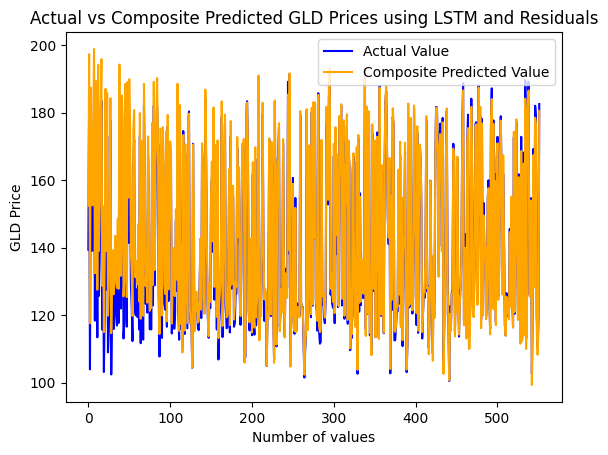

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to fetch historical stock data using yfinance
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to calculate MAPE and SMAPE
def calculate_percentage_error(actual, predicted):
    percentage_error = np.abs((actual - predicted) / actual) * 100
    return percentage_error

def calculate_mape(actual, predicted):
    return np.mean(calculate_percentage_error(actual, predicted))

def calculate_smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = np.abs(predicted) + np.abs(actual)
    smape = (2 * np.sum(numerator) / np.sum(denominator)) * 100
    return smape

# Data collection and processing
start_date = '2013-01-02'
end_date = '2023-12-31'
ticker = 'GLD'

# Fetching historical stock data
gold_data = get_stock_data(ticker, start_date, end_date)

# Extracting the closing prices
prices = gold_data['Close'].values.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Creating sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10  # You can adjust this parameter based on your data
X = create_sequences(prices_scaled, seq_length)
Y = prices_scaled[seq_length:]

# Splitting into Training and Test Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Reshaping data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Model Training: LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=32)

# Prediction on Test Data
test_data_prediction = model.predict(X_test)
test_data_prediction = scaler.inverse_transform(test_data_prediction)

# Inverse transform for actual values
Y_test = scaler.inverse_transform(Y_test)

# Decompose time series data
residuals = Y_test - test_data_prediction.flatten()

# Predict residuals using a simple model (you can use a different model for better results)
residual_model = Sequential()
residual_model.add(Dense(units=10, activation='relu', input_dim=seq_length))
residual_model.add(Dense(units=1))

residual_model.compile(optimizer='adam', loss='mean_squared_error')
residual_model.fit(X_test.reshape(-1, seq_length), residuals, epochs=50, batch_size=32)

# Predict residuals for the entire dataset
all_residuals_prediction = residual_model.predict(X.reshape(-1, seq_length))

# Composite the new time series data with predicted residuals
new_timeseries_data = test_data_prediction.flatten() + all_residuals_prediction[:len(test_data_prediction)].flatten()

# Evaluate the model with sophisticated metrics
r2 = r2_score(Y_test, test_data_prediction)
mape = calculate_mape(Y_test, test_data_prediction)
smape = calculate_smape(Y_test, test_data_prediction)

print('R-squared (R2):', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Symmetric Mean Absolute Percentage Error (SMAPE):', smape)

# Compare the actual values and the new time series data in a plot
plt.plot(Y_test, color='blue', label='Actual Value')
plt.plot(new_timeseries_data, color='orange', label='Composite Predicted Value')
plt.title('Actual vs Composite Predicted GLD Prices using LSTM and Residuals')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
65/65 [==============================] - 7s 14ms/step - loss: 0.0202
Epoch 2/50
65/65 [==============================] - 1s 12ms/step - loss: 7.1136e-04
Epoch 3/50
65/65 [==============================] - 1s 11ms/step - loss: 6.9820e-04
Epoch 4/50
65/65 [==============================] - 1s 12ms/step - loss: 6.9580e-04
Epoch 5/50
65/65 [==============================] - 1s 12ms/step - loss: 6.8616e-04
Epoch 6/50
65/65 [==============================] - 1s 14ms/step - loss: 6.9651e-04
Epoch 7/50
65/65 [==============================] - 1s 12ms/step - loss: 6.8875e-04
Epoch 8/50
65/65 [==============================] - 1s 12ms/step - loss: 6.8930e-04
Epoch 9/50
65/65 [==============================] - 1s 14ms/step - loss: 6.5386e-04
Epoch 10/50
65/65 [==============================] - 1s 21ms/step - loss: 6.6417e-04
Epoch 11/50
65/65 [==============================] - 1s 21ms/step - loss: 6.4353e-04
Epoch 12/

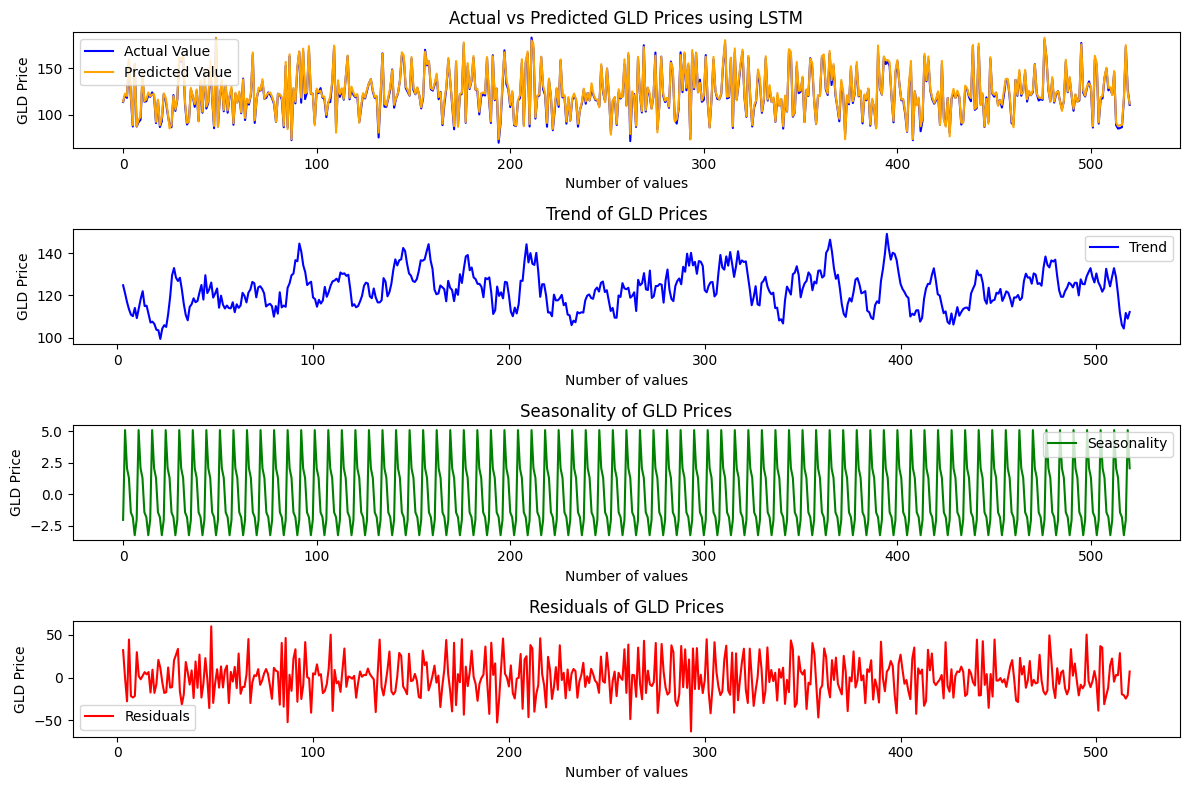

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to fetch historical stock data using yfinance
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to calculate MAPE and SMAPE
def calculate_percentage_error(actual, predicted):
    percentage_error = np.abs((actual - predicted) / actual) * 100
    return percentage_error

def calculate_mape(actual, predicted):
    return np.mean(calculate_percentage_error(actual, predicted))

def calculate_smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = np.abs(predicted) + np.abs(actual)
    smape = (2 * np.sum(numerator) / np.sum(denominator)) * 100
    return smape

# Data collection and processing
start_date = '2008-01-02'
end_date = '2018-05-16'
ticker = 'GLD'

# Fetching historical stock data
gold_data = get_stock_data(ticker, start_date, end_date)

# Extracting the closing prices
prices = gold_data['Close'].values.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Creating sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10  # You can adjust this parameter based on your data
X = create_sequences(prices_scaled, seq_length)
Y = prices_scaled[seq_length:]

# Splitting into Training and Test Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Reshaping data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Model Training: LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=32)

# Prediction on Test Data
test_data_prediction = model.predict(X_test)
test_data_prediction = scaler.inverse_transform(test_data_prediction)

# Inverse transform for actual values
Y_test = scaler.inverse_transform(Y_test)

# ...

# Decompose time series data
result = seasonal_decompose(Y_test, model='additive', period=7)  # Assuming weekly seasonality
trend = result.trend
seasonal = result.seasonal
residuals = result.resid

# ...



# Predict residuals using a simple model (you can use a different model for better results)
residual_model = Sequential()
residual_model.add(Dense(units=10, activation='relu', input_dim=seq_length))
residual_model.add(Dense(units=1))

residual_model.compile(optimizer='adam', loss='mean_squared_error')
residual_model.fit(X_test.reshape(-1, seq_length), residuals, epochs=50, batch_size=32)

# Predict residuals for the entire dataset
all_residuals_prediction = residual_model.predict(X.reshape(-1, seq_length))

# Composite the new time series data with predicted residuals
new_timeseries_data = test_data_prediction.flatten() + all_residuals_prediction[:len(test_data_prediction)].flatten()

# Evaluate the model with sophisticated metrics
r2 = r2_score(Y_test, test_data_prediction)
mape = calculate_mape(Y_test, test_data_prediction)
smape = calculate_smape(Y_test, test_data_prediction)

print('R-squared (R2):', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Symmetric Mean Absolute Percentage Error (SMAPE):', smape)

# Plotting trend, seasonality, and residuals with timeline in legend
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(Y_test, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value')
plt.title('Actual vs Predicted GLD Prices using LSTM')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, color='blue', label='Trend')
plt.title('Trend of GLD Prices')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, color='green', label='Seasonality')
plt.title('Seasonality of GLD Prices')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residuals, color='red', label='Residuals')
plt.title('Residuals of GLD Prices')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()

plt.tight_layout()
plt.show()
